# Human Activity Recognition in Videos using Keras (CNN + LSTM)



## Some basics

Reference: [Human Activity Recognition using TensorFlow (CNN + LSTM) 2 Methods](https://youtu.be/QmtSkq3DYko?si=ThDkufOTLLGUxLTG)

Video Classification? 2 ways

**Single frame CNN classification system**
1. Split video into images, pass each image through an image classifier to get prediction per frame. Predict most common prediction as answer.
2. To improve upon this we can average across prediction probabilities. In most prediction networks, at the end we have a softmax layer which outputs prediction probabilities. So, if we average across class probabilities of all the frames. Then we have a more robust prediction.

Although this approach may work well, but it can run into problems because it doesn't take into account the temporal nature of video. How? Because in each frame we consider the spatial information, i.e. where the objects are location in the frame. But we disragard the temporal information if we just average across the probabilities. **Hence temporal information is very important**.

I will watch the video first, then I will make notes.

## Outline

- Step 1: Download and visualize the data with its labels.
- Step 2: Preprocess the dataset
- Step 3: Split the data into train and test set
- Step 4: Implement the ConvLSTM approach
 - Step 4.1: Construct the model
 - Step 4.2: Compile & train the model
 - Step 4.3: Plot model's loss and accuracy curves
- Step 5: Implement the LRCN approach
 - Step 5.1: Construct the model
 - Step 5.2: Compile and train the model
 - Step 5.3: Plot model's loss and accuracy curves
- Step 6: Test the best performing model on youtube videos

## Code

### Importing and installing the libraries

In [1]:
# Discard the output of this cell
%%capture

# install the required libraries
!pip install pafy youtube-dl moviepy

In [2]:
# import the required libraries as you require
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import datetime as dt

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# set up numpy, python and tensorflow seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)                # numpy seed
random.seed(seed_constant)                   # python seed
tf.random.set_seed(seed_constant)            # tensorflow seed

### Step 1: Download and visualize the data with its labels
This step is to get familiar with the dataset. We will use UCF50-Action Recognition Dataset. The dataset contains:
- 50 action categories
- 25 groups of videos per action category
- 133 average videos per category
- 199 average number of frames per video
- 320 average frame width per video
- 240 average frame height per video
- 26 average frames per second per video

In [4]:
# Discard the output of this cell
%%capture

# Downloading the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the dataset
!unrar x UCF50.rar

For visualization, we pick 20 random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written.

50


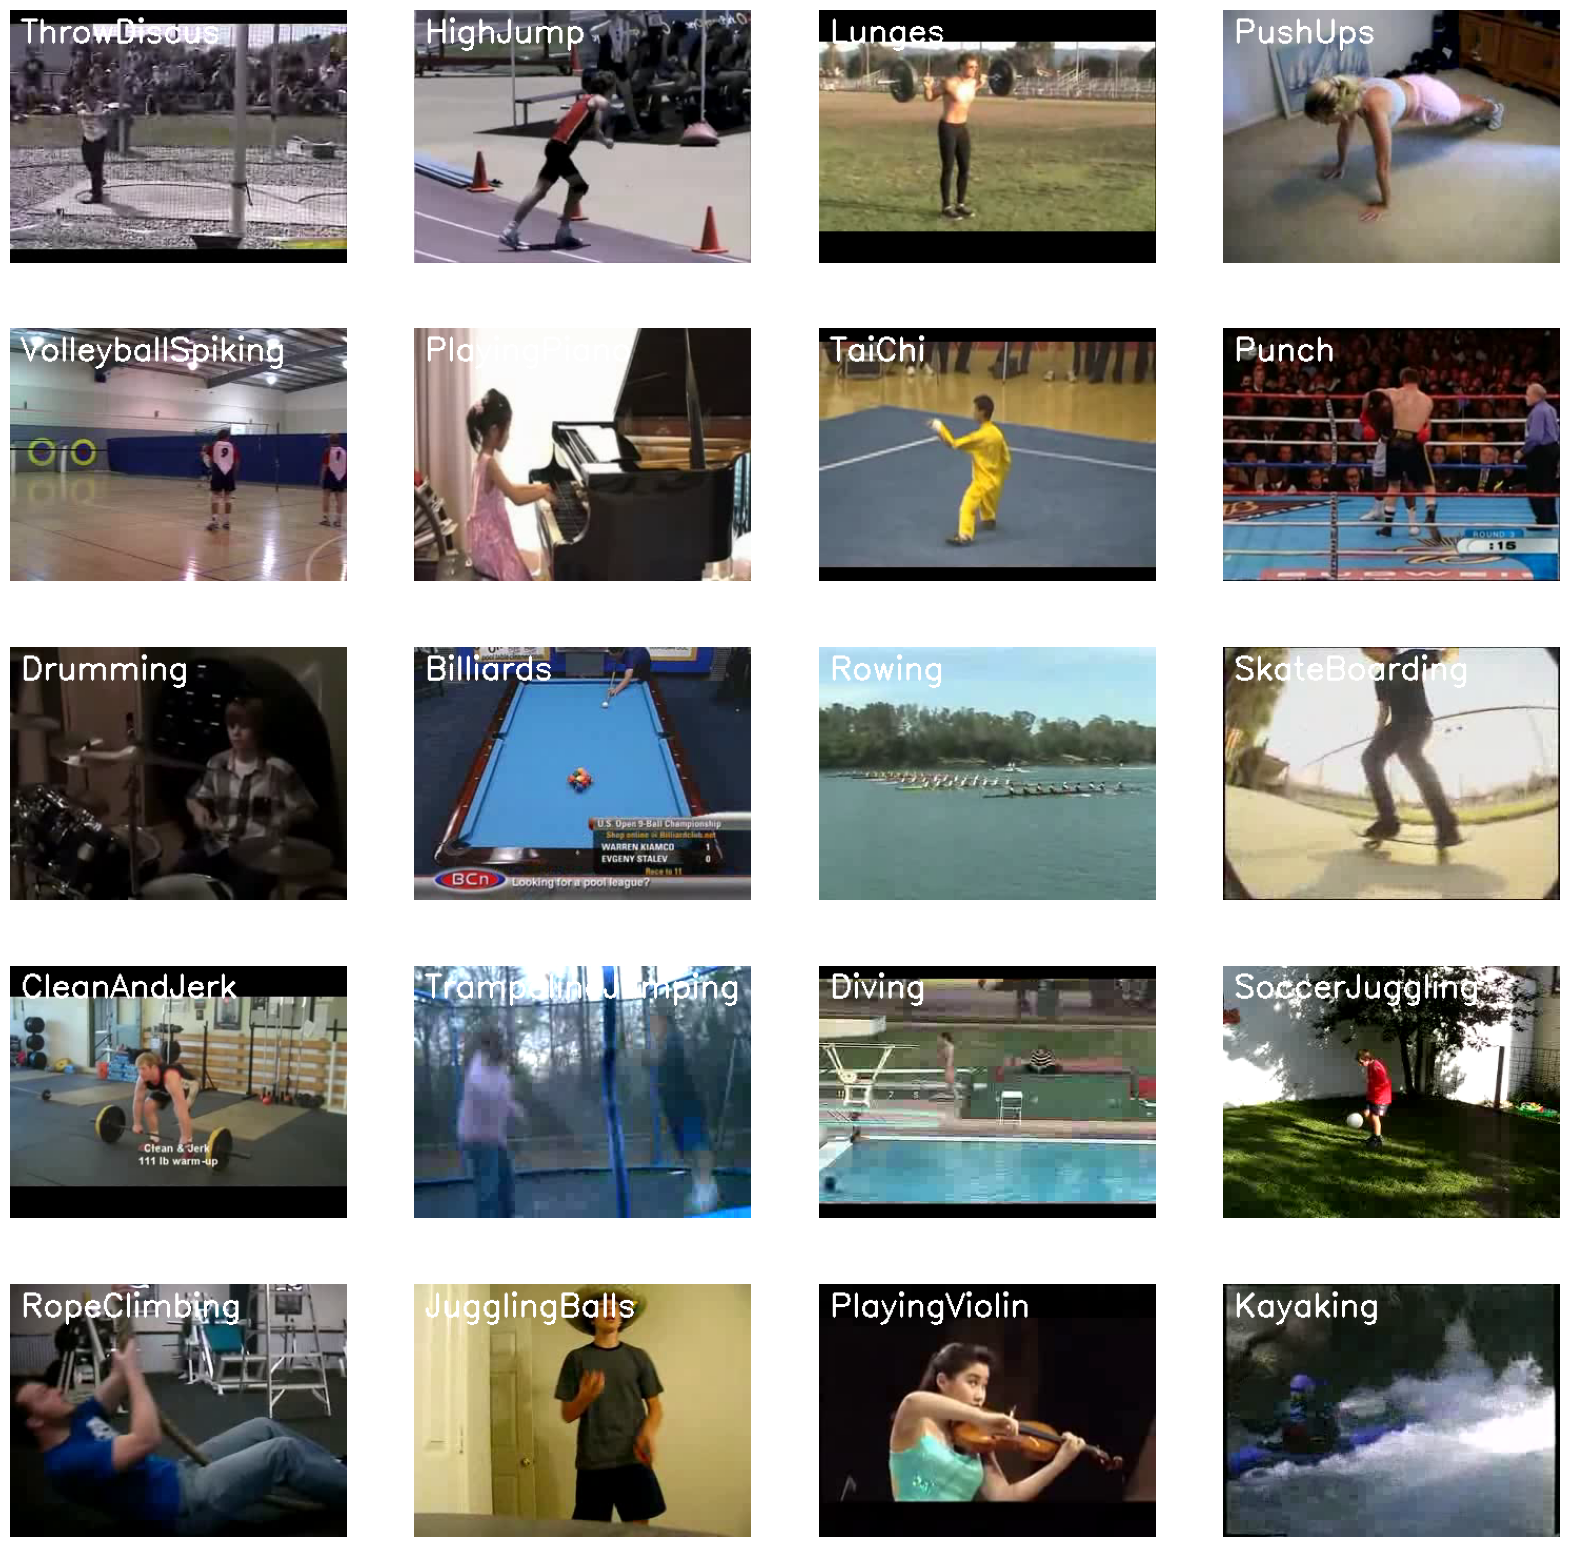

In [5]:
# create a matplotlib figure and specify the figure size
plt.figure(figsize=(20,20))

all_classes_names = os.listdir('UCF50')    # get the names of all classes in dataset
print(len(all_classes_names))              # 50 classes


# generate a list of 20 random values. The values are between 0-50,
# 50 is the total classes
random_range = random.sample(
    range(len(all_classes_names)), 20
)

# iterating over all the generated random values
for counter, random_index in enumerate(random_range, 1):

  # retrieve a classname using the randomly index
  selected_class_name = all_classes_names[random_index]

  # retrieve the filenames of the videos present in the randomly selected class directory
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

  # randomly select a video file from the list retrived from the randomly selected class directory
  selected_video_fname = random.choice(video_files_names_list)

  # initialize the VideoCapture object to read from the video file
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_fname}')

  # reading the first frame of the video
  _, bgr_frame = video_reader.read()

  # release the VideoCapture object
  video_reader.release()

  # convert the frame from BGR to RGB format
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # write class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  # display the frame
  plt.subplot(5,4, counter); plt.imshow(rgb_frame); plt.axis('off')

### Step 2: Preprocess the dataset

- read the video files from the dataset and resize the frames of the videos to a fixed height and width.
- divide each pixel by 255 to normalize the data to range [0,1], to reduce the computation. It makes convergence faster while training the network.

In [6]:
# specify the height and width to which each frame will be resized
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

# specify directory containing the dataset
DATASET_DIR = 'UCF50'

# specify the list containing the names of classes used for training
# Feel free to choose the classes
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]     # to keep the tutorial short and reduce the training time

**Note:** `IMAGE_EHIGHT`, `IMAGE_WIDTH` and `SEQUENCE_LENGTH` constants can be increased for better results, although increasing the sequence length is only effective to a certain point and increasing the calues will result in the process being more computationally expensive.

#### **Create a function to extract, resize and normalize frames**

The function will accept the path of the video as argument, and the target size. It will output the list of the resized, normalized frames of the video, whose path was inputed.

The function will read the video frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequences length of frames.

In [7]:
def frames_extraction(vpath):
  '''
  This function will extract the required frames from a video after resizing and normalizing them.
  Args:
      vpath: The path of the cideo in the disk, whose frames are to be extracted.
  Returns:
      frames_list: A list containing the resized and normalized frames of the video
  '''

  # to store video frames
  frames_list = []

  # read the video file using VideoCapture object
  video_reader = cv2.VideoCapture(vpath)

  # get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # calculate the interval after which frame will be added to the list
  skip_frames_window = max(
      int(video_frames_count/SEQUENCE_LENGTH), 1
  )

  # iterate through video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    # set the frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # reading that particular frame from the video
    success, frame = video_reader.read()

    # check if video frame is read successfully, otherwise break the loop
    if not success:
      break

    # the code below is if the frame is read correctly
    # resize the frame
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # normalize the resized frame
    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  # release the VideoCapture object
  video_reader.release()

  # return the frames list
  return frames_list

#### **Create a function for dataset creation**

We need to perform the operation of frame_extraction for multiple videos in multiple categories, to create our training data.

For this we create another function `create_dataset()` :
- that will iterate through all the specified classes in the `CLASSES_LIST` constant.
- will call the function `frame_extraction()` on every video file of the selected classes
- will return the frames (`features`), class index (`labels`), and video file path (`video_files_paths`)

In [8]:
def create_dataset():
  '''
  This function will extract the data of the selected classes and create the required dataset.
  The required dataset consists of the preprocessed frames from all the categories in one list.
  It is a list of lists of frames.
  A labels list will also be returned which will have class labels of all the list of frames.
  Returns:
      features:             A list containing the extracted frames of the videos. (preprocessed frames)
      labels:               A list containing the indexes of the classes associated with the video.
      video_files_paths:    A list containing the paths of the videos in the disk.
  '''

  # empty lists to store the features, labels, and video file paths
  features = []
  labels = []
  video_files_paths = []

  # iterating over all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):

    # Display the name of the class whose data is being extracted
    print(f'Extracting data of class: {class_name}')

    # get the list of videos present in specific class name directory
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    # iterate through all the files present in the files list
    for file_name in files_list:

      # get complete video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      # extract frames of the video file
      frames = frames_extraction(video_file_path)

      # check if the extracted frames are equal to the SEQUENCE LENGTH specified above as a constant
      # otherwise, ignore the videos having frames less than the SEQUENCE LENGTH
      if len(frames) == SEQUENCE_LENGTH:

        # Append the data to their respective lists
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # converting the lists to numpy arrays
  features = np.asarray(features)
  labels = np.asarray(labels)

  # return the frames, class index, and video files paths
  return features, labels, video_files_paths

Now we will utilize the function `create_dataset()` to extract the data of the selected classes and create the required dataset.

In [9]:
# create the dataset
features, labels, video_files_paths = create_dataset()

Extracting data of class: WalkingWithDog
Extracting data of class: TaiChi
Extracting data of class: Swing
Extracting data of class: HorseRace


Now we will convert `labels` i.e. class indexes into one-hot encoded vectors.

In [10]:
# using keras' to_categorical method to convert labels into one-hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)

***Now all the preprocessing steps are done.***

### Step 3: Split the dataset into train and test set

We have the required dataset:
- `features`, a numpy array containing all the extracted and preprocessed frames.
- `one_hot_encoded_labels`, a numpy array containing all class lables in one hot encoded format.

We split our dataset to create the training and testing sets. We will also shuffle the dataset before splitting to avoid any bias. This way we wil get splits representing the overall distribution of the data.

In [11]:
# split the data into train (75%) and test set (25%).
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size = 0.25,
    shuffle = True,
    random_state = seed_constant
)

### Step 4: Implement the ConvLSTM approach

We will implement the first approach by using a combination of ConvLSTM cells.

*A ConvLSTM cell is a variant of an LSTM network that contains convolution operations in the network. It is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.*

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolutional structure, the ConvLSTM is capable of taking in 3-D input (width, height, num_of_channels) whereas a simple LSTM only takes in 1-D input. Hence an LSTM is compatible in modelling spatio-temporal data on its own.

The paper on this approach is [Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting](https://paperswithcode.com/paper/convolutional-lstm-network-a-machine-learning) by Xingjian Shi et.al. (NIPS 2015). You can learn more about the architecture from the paper.



In [12]:
def create_convlstm_model():
  '''
  This function will construct the required convlstm model.
  Returns:
      model: It is the required constructed convlstm model.
  '''

  # we will use a sequential model for model construction
  model = tf.keras.models.Sequential()

  # --------------------BEGIN MODEL ARCHITECTURE-----------------------
  # defining the model architecture

  # ConvLSTM layer
  model.add(ConvLSTM2D(
      filters=4,
      kernel_size=(3,3),
      activation='tanh',
      data_format='channels_last',
      recurrent_dropout=0.2,
      return_sequences=True,
      input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  ))

  # MaxPooling3D layer
  model.add(MaxPooling3D(
      pool_size=(1,2,2),
      padding='same',
      data_format='channels_last'
  ))

  # TimeDistributed dropout
  model.add(TimeDistributed(
      Dropout(0.2)
  ))

  # ----------------------------------
  # ConvLSTM layer
  model.add(ConvLSTM2D(
      filters=8,
      kernel_size=(3,3),
      activation='tanh',
      data_format='channels_last',
      recurrent_dropout=0.2,
      return_sequences=True,
  ))

  # MaxPooling3D layer
  model.add(MaxPooling3D(
      pool_size=(1,2,2),
      padding='same',
      data_format='channels_last'
  ))

  # TimeDistributed dropout
  model.add(TimeDistributed(
      Dropout(0.2)
  ))

  # ----------------------------------
  # ConvLSTM layer
  model.add(ConvLSTM2D(
      filters=14,
      kernel_size=(3,3),
      activation='tanh',
      data_format='channels_last',
      recurrent_dropout=0.2,
      return_sequences=True,
  ))

  # MaxPooling3D layer
  model.add(MaxPooling3D(
      pool_size=(1,2,2),
      padding='same',
      data_format='channels_last'
  ))

  # TimeDistributed dropout
  model.add(TimeDistributed(
      Dropout(0.2)
  ))

  # ----------------------------------
  # ConvLSTM layer
  model.add(ConvLSTM2D(
      filters=16,
      kernel_size=(3,3),
      activation='tanh',
      data_format='channels_last',
      recurrent_dropout=0.2,
      return_sequences=True,
  ))

  # MaxPooling3D layer
  model.add(MaxPooling3D(
      pool_size=(1,2,2),
      padding='same',
      data_format='channels_last'
  ))

  # # TimeDistributed dropout
  # model.add(TimeDistributed(
  #     Dropout(0.2)
  # ))

  model.add(Flatten())

  model.add(Dense(
      len(CLASSES_LIST),
      activation='softmax'
  ))


  # -----------------------END OF ARCHITECTURE--------------------------------
  # display the model summary
  model.summary()

  # return the model
  return model

We utilize the function `create_convlstm_model()` created above, to construct the required `convlstm` model.

In [13]:
# construct the required convlstm model
convlstm_model = create_convlstm_model()

# display the success message
print('Model created successfully!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

#### **Check model structure:**

We have a function called `plot_model()`. We can use it to check the model layer structure.

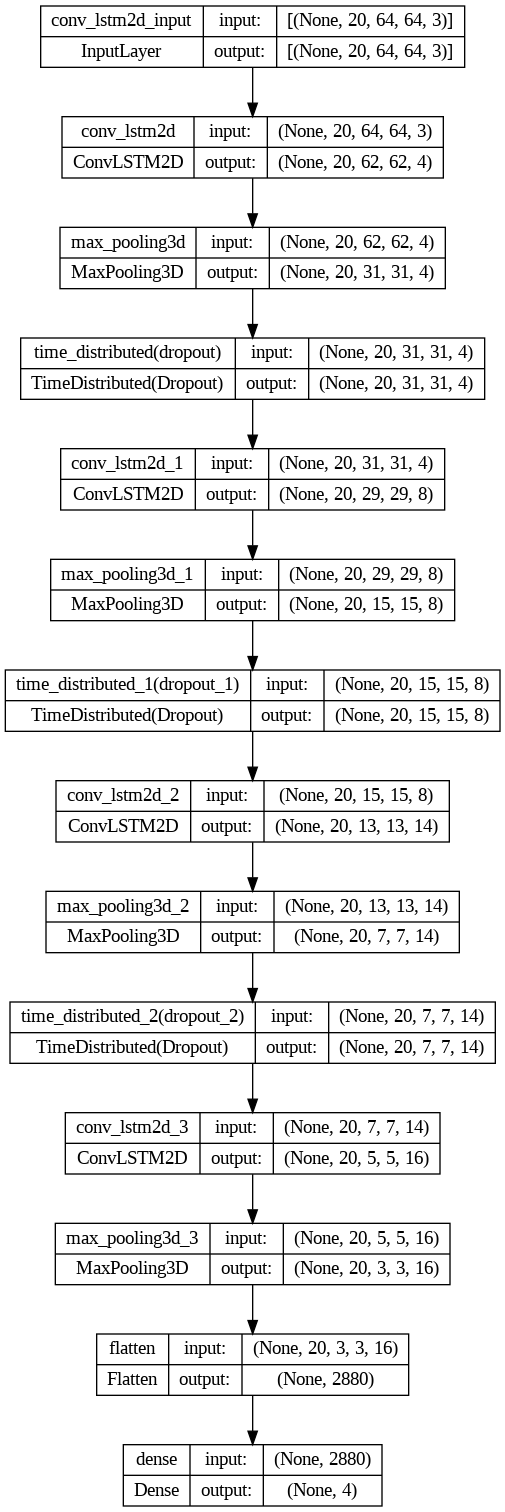

In [14]:
# plot the structure of the constructed model
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

#### Step 4.2: Compile and train the model

We will add an early stopping callback to prevent overfitting and start the training after compiling the model.

In [ ]:
# create an instance of EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# compile the model and specify loss funtion, optimizer and metrics values to the model
convlstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=["accuracy"]
)

# start the training of the model
convlstm_model_training_history = convlstm_model.fit(
    x=features_train,
    y=labels_train,
    batch_size=4,
    epochs=50,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
73/73 [==============================] - 270s 4s/step - loss: 1.3861 - accuracy: 0.2158 - val_loss: 1.3513 - val_accuracy: 0.4110
Epoch 2/50
73/73 [==============================] - 249s 3s/step - loss: 1.2694 - accuracy: 0.4110 - val_loss: 1.1687 - val_accuracy: 0.3836
Epoch 3/50
73/73 [==============================] - 203s 3s/step - loss: 1.0898 - accuracy: 0.5171 - val_loss: 1.1986 - val_accuracy: 0.5205
Epoch 4/50
73/73 [==============================] - 220s 3s/step - loss: 0.9480 - accuracy: 0.6233 - val_loss: 1.0338 - val_accuracy: 0.6164
Epoch 5/50
73/73 [==============================] - 235s 3s/step - loss: 0.7515 - accuracy: 0.7089 - val_loss: 0.9188 - val_accuracy: 0.5753
Epoch 6/50
73/73 [==============================] - 258s 4s/step - loss: 0.5835 - accuracy: 0.7774 - val_loss: 0.7927 - val_accuracy: 0.6575
Epoch 7/50
73/73 [==============================] - 271s 4s/step - loss: 0.4265 - accuracy: 0.8390 - val_loss: 0.7877 - val_accuracy: 0.6986
Epoch 8/50
73

#### **Evaluate the trained model**

After training, we evaluate the model on the test set.

In [ ]:
# evaluate the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

#### **Save the model**
Now we will save the model to avoid training it from scratch every time we need the model.

The method `save('file_name')` can be used to save the model. A good practice is to name the file as the same as model name and give date and time.

In [ ]:
# get the loss and accuracy from the model evaluation history
evaluation_loss, evaluation_accuracy = model_evaluation_history

# define the string data-time format
date_time_format = '%Y_%m_%d__%H_%M_%S'

# get the current date and time in a DateTime object
current_date_time_dt = dt.datetime.now()

# convert DateTime object to string, according to the mentioned format
current_date_time_str = dt.datetime.strftime(current_date_time_dt, date_time_format)

# define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'convlstm_model__datetime_{current_date_time_str}__loss_{evaluation_loss}__accuracy__{evaluation_accuracy}.h5'


# save the model
convlstm_model.save(model_file_name)

#### Step 4.3: Plot model's loss and accuracy curves

We create a function `plot_metric()` to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize those.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
  This function will plot the metrics passed to it in a graph.
  Args:
      model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs.
      metric_name_1:          The name of the first metric that needs to be plotted in the graph
      metric_name_2:          The name of the second metric that needs to be plotted in the graph
      plot_name:              The title of the graph
  '''

  # get metric values using metric names as identifiers.
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # construct a range object which will be used as x-axis (horizontal plane) of the graph
  epochs = range(len(metric_value_1))

  # plot the graph
  plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

  # add title to the plot
  plt.title(str(plot_name))

  # add legend to the plot
  plt.legend()

We utilize this function `plot_metric()`, to visualize and understand the metric trends.

In [ ]:
# visualize the training and validation loss metrics together
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# visualize the training and validation accuracy metrics
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### Step 5: Implement the LRCN approach

We implement LRCN approach by combining Convolution and LSTM layers in a single model.

At the beginning of tutorial we talked about convolutional network + LSTM approach. We saw one method to implement it through ConvLSTM cell, which is an implicit method.

How to separately use CNN and LSTM?

1. Using separately trained CNN and LSTM network, then fine tune for the problem

2. LRCN Approach (Long Term Recurrent Convolutional Network), which combines CNN and LSTM layers in a single model.

Here we will use the second approach.


The convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time steps for temporal sequence modelling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

Read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description]() by Jeff Donahue et. al. (CVPR 2015), to learn about the architecture.

We will also use `TimeDistributed` wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape (no_of_frames, width, height, num_of_channels) if originally the input shape was (width, height, num_of_channels). This is beneficial as it allows to input the whole video into the model in a single shot.

### Step 5.1: Construct the model

To implement LRCN, we will use:
- `TimeDistributed` `Conv2D` layers, which will be followed by
- `MaxPooling2D` and `Dropout` layers
- The extracted features from these will be flattened using `Flatten` layer.
- Then will be fed to `LSTM` layer.
- The `Dense` layer with softmax activation will then use the output of `LSTM` layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
  '''
  This function will construct the required LRCN model.
  Returns:
      model: It is the required LRCN model
  '''

  # we will use sequential model for model construction
  model = tf.keras.models.Sequential()

  # --------------------BEGIN MODEL ARCHITECTURE-----------------

  model.add(TimeDistributed(
      Conv2D(16, (3,3), padding='same', activation='relu'),
      input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  ))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  #-----------------------END MODEL ARCHITECTURE------------------

  # display model summary
  model.summary()

  # return the constructed model
  return model

We will utilize `create_LRCN_model()` function above to construct the required LRCN model.

In [ ]:
# construct the required LRCN model
lrcn_model = create_LRCN_model()

# display the success message
print('Model created successfully!')

#### Check model structure

Using the `plot_model()` function, we will check the structure of the constructed LRCN model.

In [ ]:
plot_model(lrcn_model, to_file='lrcn_model_structure_plot.png', show_shapes=True, show_layer_names=True)

### Step 5.2: Compile and train the model

After checking the structure we will compile and train the model.

In [ ]:
# create an instance of early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patence=15,
    mode='min',
    restore_best_weights=True
)

# compile the model and specify loss function, optimizer and metrics
lrcn_model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics = ['accuracy']
)

# start the training
lrcn_model_training_history = lrcn_model.fit(
    x = features_train,
    y = labels_train,
    epochs = 50,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    callbacks = [early_stopping_callback]
)

#### Evaluating the model
As done for the previous model, we will evaluate the LRCN model on the test set.

In [ ]:
# evaluate the trained model
model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

#### Save the model

Now, we will save the model for future uses. For this we will use the same technique we previously used.

In [ ]:
# get the loss and accuracy from the model evaluation history
evaluation_loss, evaluation_accuracy = model_evaluation_history

# define the string data-time format
date_time_format = '%Y_%m_%d__%H_%M_%S'

# get the current date and time in a DateTime object
current_date_time_dt = dt.datetime.now()

# convert DateTime object to string, according to the mentioned format
current_date_time_str = dt.datetime.strftime(current_date_time_dt, date_time_format)

# define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'lrcn_model__datetime_{current_date_time_str}__loss_{evaluation_loss}__accuracy__{evaluation_accuracy}.h5'



# saving the model
lrcn_model.save(model_file_name)

### Step 5.3: Plot model's loss and accuracy curves

We will use the `plot_metric()` function defined above to plot.

In [ ]:
# plot the training and validation loss per epoch
plot_metric(lrcn_model_training_history, 'loss', 'val_loss', 'Total_Loss vs Total_Validation_Loss')

In [ ]:
# plot the training and validation accuracy per epoch
plot_metric(lrcn_model_training_history, 'accuracy', 'val_accuracy', 'Total_Accuracy vs Total_Validation_Accuracy')